### This notebook implements regression models on the QSAR data sets generated by the data_analysis.ipynb notebook

In [279]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
import cmath
import random
from sklearn.utils.validation import column_or_1d

import deepchem as dc

import tensorflow as tf
from tensorflow import keras

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

%matplotlib inline
sns.set()

## Classes

class Models():
    
    def __init__(self, data, model_name):
        self.data = data
        self.model_name = model_name
        
    def fit_cross_validated_model(self, model, cv=3, 
                                  metric=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'], 
                                 return_trains_scores=False, return_estimator=True):
        """Perform cross-validation for a model and plot the average error 
        metrics for the folds (3 by default)"""
        scores = cross_validate(model, cv=cv, metric=metric, return_train_score=return_train_score, 
                                return_estimator=return_estimator)

        return scores
        
    def calculate_cross_validation_stats(self, scores, verbose=True):
        """Calculate stats for a group of cross-validation models scores. 
        The scores dictionary is expected to contain error metrics for the models."""
        stats = {}
        stats[self.model_name] = {'means': [-1 * scores['test_neg_mean_absolute_error'].mean(), 
                                            -1 * scores['test_neg_mean_squared_error'].mean(), 
                                            scores['test_r2'].mean()], 
                                  'stds': [-1 * scores['test_neg_mean_absolute_error'].std(),
                                           -1 * scores['test_neg_mean_squared_error'].std(),
                                           scores['test_r2'].std()]}
        if verbose:
            print("Average MAE for %s model: %0.3f (+/- %0.3f)" % (model_name, stats[model_name]['means'][0], 
                                                                   stats[model_name]['stds'][0]))
            print("Average MSE for %s model: %0.3f (+/- %0.3f)" % (model_name, stats[model_name]['means'][1], 
                                                                   stats[model_name]['stds'][1]))
            print("Average R2 for %s model: %0.3f (+/- %0.3f)" % (model_name, stats[model_name]['means'][2], 
                                                                  stats[model_name]['stds'][2]))
            
        return stats
    
    def evaluate_cross_validated_models(self, scores, X, y):
        """Evaluate a group of models on a validation or test data set and plot results. If a regresion model 
        is passed, also plot residuals analysis."""
        best_r2 = 0
        best_model = None
        for i in range(len(scores['estimator'])):
            cv_model = scores['estimator'][i]
            pred = cv_model.predict(X)
            r2 = metrics.r2_score(y, pred)
            if r2 > best_r2:
                best_r2  = r2
                best_model = cv_model
        print("best model: %s r2 score: %0.2f" % (i, best_r2))
        return best_model
                

def train_valid_test_split(y, frac_train=0.8, frac_valid=0.1, frac_test=0.1, seed=None):
    """Perform stratified split of data set and return indices to ensure equal distribution of 
    y-values across train, valid, and test data sets"""
    if not seed is None:
        np.random.seed(seed)
    split_cd = 10
    train_cutoff = int(np.round(frac_train * split_cd))
    valid_cutoff = int(np.round(frac_valid * split_cd)) + train_cutoff
    test_cutoff = int(np.round(frac_test * split_cd)) + valid_cutoff

    train_idx = np.array([], dtype=int)
    valid_idx = np.array([], dtype=int)
    test_idx = np.array([], dtype=int)
    
    sortidx = np.argsort(y)
    
    i = 0
    while sortidx.shape[0] >= split_cd:
        #print("split iteration: ", i, "remaining data:", sortidx.shape[0])
        old = split_cd * i
        i +=1
        new = split_cd * i
        sortidx_split, sortidx = np.split(sortidx, [split_cd])
        shuffled = np.random.permutation(range(old, new))
        train_idx = np.hstack([train_idx, sortidx_split[shuffled[:train_cutoff]]])
        valid_idx = np.hstack(
          [valid_idx, sortidx_split[shuffled[train_cutoff:valid_cutoff]]])
        test_idx = np.hstack([test_idx, sortidx_split[shuffled[valid_cutoff:]]])

    # Append remaining examples to train
    if sortidx.shape[0] > 0: np.hstack([train_idx, sortidx])
    
    return train_idx, valid_idx, test_idx


correlation_selected = pd.read_csv("qsar_correlation_processed.csv")
lasso_selected = pd.read_csv("qsar_lasso_processed.csv")


### Use stratified dataset split to ensure equal distribution of logRA values across set

The histogram plots show a roughly equal distribution of log RA values across the different splits. The plots also show that the log RA values are not normally distributed throughout the data set. In particular, there are several molecules (~20) that have the same log RA value of -4. Data analysis showed that these molecules are structurally diverse, with different values for the global moleculear descriptors. Consequently, these samples might be outliers, or indeed the feature set of molecular descriptors is insufficient to accuratly describe molecules with the same log RA values. 

processing: correlation
(136, 85) (136, 1)
(17, 85) (17, 1)
(17, 85) (17, 1)
processing: lasso
(136, 61) (136, 1)
(17, 61) (17, 1)
(17, 61) (17, 1)


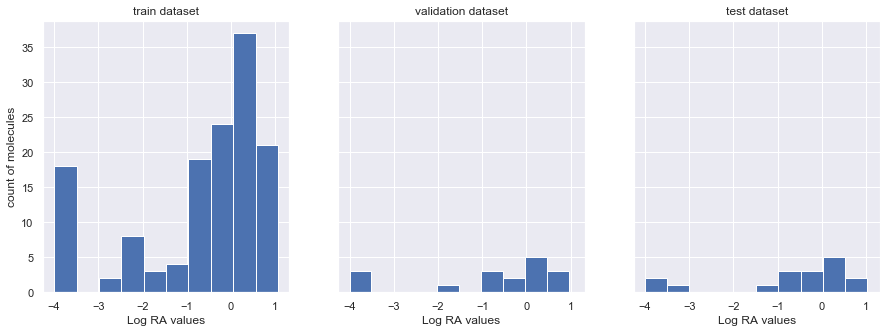

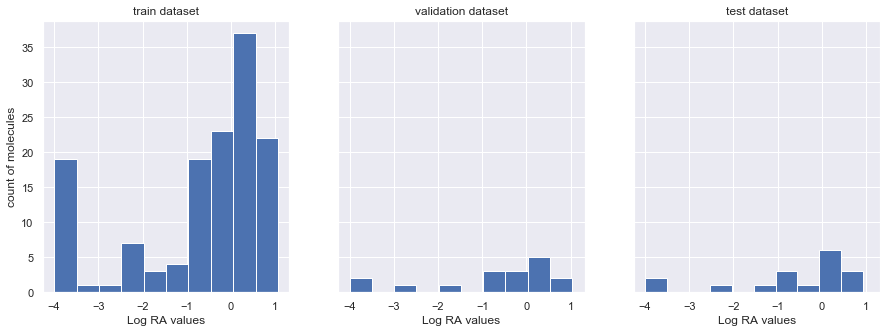

In [242]:
## Data dictionary

data = {'correlation': {'df': correlation_selected}, 
        'lasso': {'df': lasso_selected}}

## Perform splits for data sets

for d in data:
    print("processing: %s" % d)
    # Feature set should include all columns except for the label y 
    y = np.array(data[d]['df']['y_var']).reshape(-1,1)
    X = np.array(data[d]['df'].drop('y_var', axis=1))
    train_idx, valid_idx, test_idx = train_valid_test_split(data[d]['df']['y_var'])
    #train_idx, valid_idx, test_idx = train_valid_test_split(y)
    
    # Apply split
    X_train, y_train = (np.array(X[train_idx]), np.array(y[train_idx]))
    X_valid, y_valid = (np.array(X[valid_idx]), np.array(y[valid_idx]))
    X_test, y_test = (np.array(X[test_idx]), np.array(y[test_idx]))

    print(X_train.shape, y_train.shape)
    print(X_valid.shape, y_valid.shape)
    print(X_test.shape, y_test.shape)
    
    data[d]['train_datasets'] = [X_train, y_train]
    data[d]['valid_datasets'] = [X_valid, y_valid]
    data[d]['test_datasets'] = [X_test, y_test]


## Distribution of Log RA values across data splits

def plot_dataset_split_distributions(data, name):
    fix, ax = plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=True)
    plt.title("Histogram of Log RA values for %s dataset" % name)
    ax[0].hist(data[name]['train_datasets'][1])
    ax[0].set_title("train dataset")
    ax[0].set_xlabel("Log RA values")
    ax[0].set_ylabel("count of molecules")
    ax[1].hist(data[name]['valid_datasets'][1])
    ax[1].set_title("validation dataset")
    ax[1].set_xlabel("Log RA values")
    ax[2].hist(data[name]['test_datasets'][1])
    ax[2].set_title("test dataset")
    ax[2].set_xlabel("Log RA values")
    plt.show()

    
plot_dataset_split_distributions(data, 'correlation') 
plot_dataset_split_distributions(data, 'lasso') 

## Sanity check for stratified sampling compared to random sampling 




In [232]:

# Pipelines

ridge_ = linear_model.RidgeCV(cv=3, alphas=[1e-2, 1e-1, 1, 10], gcv_mode='auto')
elastic_cv_ = linear_model.ElasticNetCV(cv=3, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
                                     alphas=[1e-1, 1, 10], random_state=42)
pca_model = PCA(n_components=0.95, svd_solver='full')
scaler = preprocessing.StandardScaler()

ridge = Pipeline([('scaler', scaler),
                  ('ridge', ridge_)])

elastic = Pipeline([('scaler', scaler),
                  ('elastic', elastic_cv_)])

pca_ridge = Pipeline([('scaler', scaler),
                  ('pca', pca_model),
                  ('ridge', ridge_)])

pca_elastic = Pipeline([('scaler', scaler),
                        ('pca', pca_model),
                        ('elastic', elastic_cv_)])


models = {'ridge': ridge, 'elastic': elastic, 'pca_ridge': pca_ridge, 'pca_elastic': pca_elastic}
results = []
names = []

def plot_rmse_path(model):
    eps = model.steps[-1][1].eps
    m_log_alpha = -np.log10(model.steps[-1][1].alpha_ + eps)
    m_log_alphas = -np.log10(model.steps[-1][1].alphas_ + eps)

    print("optimal alpha chosen by CV on 3 folds: ", m_log_alpha)
    plt.figure(figsize=(12,10))
    plt.plot(m_log_alphas, model.steps[-1][1].mse_path_, ':')
    plt.plot(m_log_alphas, model.steps[-1][1].mse_path_.mean(axis=-1), 'k',
             label='Average across the folds', linewidth=2)
    plt.axvline(m_log_alpha, linestyle='--', color='k',
                label='alpha: CV estimate')
    plt.legend()
    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.title('Mean square error on each fold: coordinate descent')
    plt.axis('tight')
    #plt.ylim(ymin, ymax)
    plt.show()

for d in data:
    scores = {}
    for m in models:
        print("data: ", d, "--- model: ", m)
        fitted_model = models[m].fit(data[d]['train_datasets'][0], data[d]['train_datasets'][1].ravel())
        score = fitted_model.score(data[d]['valid_datasets'][0], data[d]['valid_datasets'][1].ravel())
        print("optimal alpha chosen by CV on 3 folds: ", models[m].steps[-1][1].alpha_)
        print("R2 Score on validation data set :", score)
        if 'elastic' in m:
            print("elastic net optimal L1-L2 ratio: ", models[m].steps[-1][1].l1_ratio_)
            #plot_rmse_path(models[m])
        scores[m] = [score]
        #print(scores)
    names.append(d)
    results.append(scores)
    
    

data:  correlation --- model:  pca_elastic
optimal alpha chosen by CV on 3 folds:  0.1
R2 Score on validation data set : 0.2889569934930386
elastic net optimal L1-L2 ratio:  0.1
data:  correlation --- model:  elastic
optimal alpha chosen by CV on 3 folds:  0.1
R2 Score on validation data set : 0.5393807697321824
elastic net optimal L1-L2 ratio:  0.1
data:  correlation --- model:  pca_ridge
optimal alpha chosen by CV on 3 folds:  10.0
R2 Score on validation data set : 0.2728458274928458
data:  correlation --- model:  ridge
optimal alpha chosen by CV on 3 folds:  10.0
R2 Score on validation data set : 0.5986706128521999
data:  lasso --- model:  pca_elastic
optimal alpha chosen by CV on 3 folds:  0.1
R2 Score on validation data set : 0.7689883230789538
elastic net optimal L1-L2 ratio:  0.5
data:  lasso --- model:  elastic
optimal alpha chosen by CV on 3 folds:  0.1
R2 Score on validation data set : 0.7512202684658047
elastic net optimal L1-L2 ratio:  0.1
data:  lasso --- model:  pca_ridge

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarn

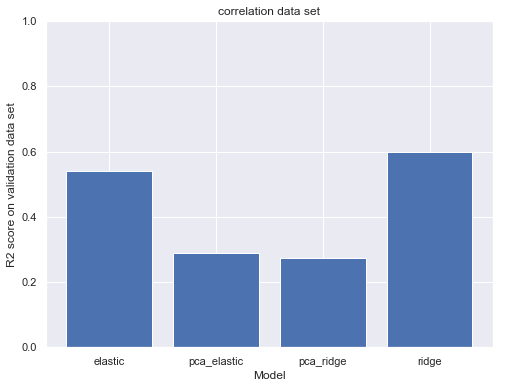

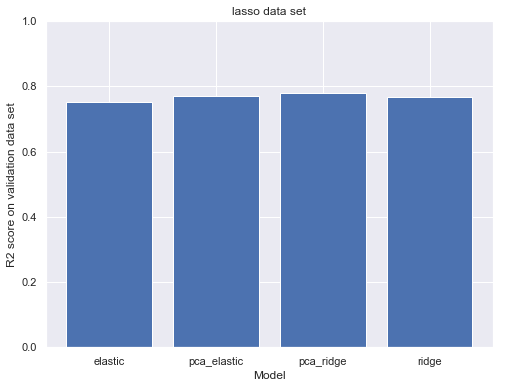

In [233]:
# iters = [0, 1]
for n, r in zip(names, results):
    plt.figure(figsize=(8,6))
    plt.ylim(0, 1)
    plt.bar(x=['elastic', 'pca_elastic', 'pca_ridge', 'ridge'],
           height=[r['elastic'][0], r['pca_elastic'][0],
                  r['pca_ridge'][0], r['ridge'][0]])
    plt.title("%s data set" % n)
    plt.xlabel("Model")
    plt.ylabel("R2 score on validation data set")
    plt.show()
    


### Cross-validation model testing 

From the previous analysis, the best performing model, on average, is the elasticnet regression model on the correlation selected dataset, without PCA.

In [300]:
class Models():
    
    def __init__(self, X_train, y_train, model_name):
        self.X_train = X_train
        self.y_train = y_train
        self.model_name = model_name
        
    def fit_cross_validated_model(self, model, cv=3, 
                                  metrics=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'], 
                                 return_train_score=False, return_estimator=True):
        """Perform cross-validation for a model and plot the average error 
        metrics for the folds (3 by default)"""
        scores = cross_validate(model, self.X_train, self.y_train, 
                                cv=cv, scoring=metrics, return_train_score=return_train_score, 
                                return_estimator=return_estimator)

        return scores
        
    def calculate_cross_validation_stats(self, scores, verbose=True):
        """Calculate stats for a group of cross-validation models scores. 
        The scores dictionary is expected to contain error metrics for the models."""
        stats = {}
        stats[self.model_name] = {'means': [-1 * scores['test_neg_mean_absolute_error'].mean(), 
                                            -1 * scores['test_neg_mean_squared_error'].mean(), 
                                            scores['test_r2'].mean()], 
                                  'stds': [-1 * scores['test_neg_mean_absolute_error'].std(),
                                           -1 * scores['test_neg_mean_squared_error'].std(),
                                           scores['test_r2'].std()]}
        if verbose:
            print("Average MAE for %s model: %0.3f (+/- %0.3f)" % (self.model_name, stats[self.model_name]['means'][0], 
                                                                   stats[self.model_name]['stds'][0]))
            print("Average MSE for %s model: %0.3f (+/- %0.3f)" % (self.model_name, stats[self.model_name]['means'][1], 
                                                                   stats[self.model_name]['stds'][1]))
            print("Average R2 for %s model: %0.3f (+/- %0.3f)" % (self.model_name, stats[self.model_name]['means'][2], 
                                                                  stats[self.model_name]['stds'][2]))
            
        return stats
    
    def evaluate_cross_validated_models(self, scores, X_validate, y_validate):
        """Evaluate a group of models on a validation or test data set and plot results. If a regresion model 
        is passed, also plot residuals analysis."""
        best_r2 = 0
        best_model = None
        for i in range(len(scores['estimator'])):
            cv_model = scores['estimator'][i]
            pred = cv_model.predict(X_validate)
            r2 = metrics.r2_score(y_validate, pred)
            if r2 > best_r2:
                best_r2  = r2
                best_model = cv_model
        print("best model: %s r2 score: %0.2f" % (i, best_r2))
        return best_model, pred
    
class Plots():
    
    def __init__(self, model_name):
        self.model_name = model_name
        
    def plot_prediction_vs_actuals(self, y_pred, y_true):
        pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
        pred_df['y_true'] = y_true
        sns.pairplot(pred_df, x_vars='y_true', y_vars='y_pred', height=7, aspect=1, kind='reg')
        plt.title(self.model_name)
        plt.annotate('$R^2$=%.2f, MSE=%.2f' % (metrics.r2_score(y_true, y_pred), 
                                               metrics.mean_absolute_error(y_true, y_pred)), 
                     xy=(0.05, 0.95), xycoords='axes fraction')
        plt.show()
        
    def plot_cross_validation_results(self, stats, names = ['MAE', 'MSE', 'R2']):
        """Plot bar charts of error metrics for cross-validated models"""
        plt.figure(figsize=(8,6))
        plt.title("Cross-validated error metrics for: %s" % self.model_name)
        plt.bar(names, stats[self.model_name]['means'], yerr=stats[self.model_name]['stds'])
        plt.show()
        
        
    def plot_residuals(self, pred, y):
        """Perform residual analysis for regression models. Calculates residual plots, 
        QQ plots, scale-location plots and standardised residual plots."""
        pred = pred.reshape(-1,1)
        residuals = pred - y
        standardised_residuals = residuals / np.sqrt(pred)
        sqrt_standardised_residuals = np.sqrt(standardised_residuals)
        fig, ax = plt.subplots(2,2, figsize=(16,10))
        ax[0,0].scatter(x=pred, y=residuals, s=40)
        ax[0,0].axhline(y=0, c='black',linestyle='--')
        ax[0,0].set_title("Residuals")
        sm.qqplot(residuals, line='s', ax=ax[0,1])
        ax[0,1].set_title("Residuals QQ Plot")
        ax[1,0].scatter(pred, sqrt_standardised_residuals, s=40)
        ax[1,0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
        #ax[1,0].axhline(y=0, c='black', linestyle='--')
        ax[1,0].set_title("Scale-Location Plot")
        ax[1,1].scatter(pred,standardised_residuals, s=40)
        ax[1,1].set_title("Standardised Residuals vs Predictions")
        ax[1,1].axhline(y=3, c='black')
        ax[1,1].axhline(y=-3, c='black')
        plt.show()
        
        
    def coefficient_plots(coefficients, columns):
        df = pd.DataFrame(coefficients, columns=['coefficients'], index=columns)
        zero_coeff = df.loc[df['coefficients'] == 0]
        print("Model picked " + str(sum(coefficients != 0)) + " variables and eliminated " +  str(sum(coefficients == 0)) + " variables")
        print("zero coefficients: ", zero_coeff.index.values)
        df.plot(kind='bar', figsize=(14,10))
        plt.ylabel("Estimated coefficients", fontsize=16)
        plt.xlabel("Feature labels", fontsize=16)
        plt.xticks(fontsize=12)
        plt.show()
        #return zero_coeff

    def count_coefficients(data, columns):
        counter = {}
        for i in data:
            counter[i] = [data.count(i)]
        coeff_counted = pd.DataFrame.from_dict(counter, orient='index').reset_index()
        coeff_counted.columns = ['feature', 'count']
        return coeff_counted

(17, 85)
(17, 1)
Average MAE for correlation_dataset model: 1.481 (+/- -0.774)
Average MSE for correlation_dataset model: 3.658 (+/- -3.271)
Average R2 for correlation_dataset model: -14.637 (+/- 9.517)


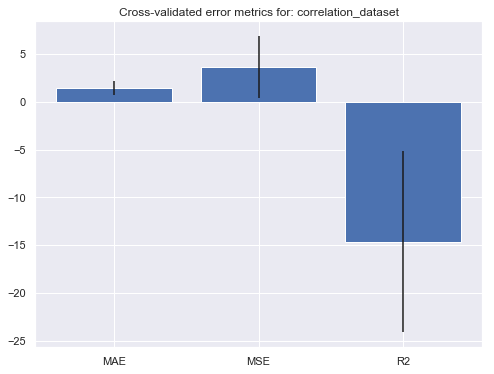

best model: 2 r2 score: 0.55
(17,)
(17, 1)


/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


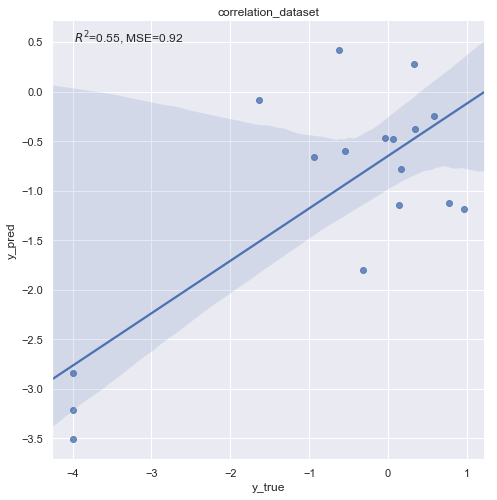

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in sqrt
/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in sqrt


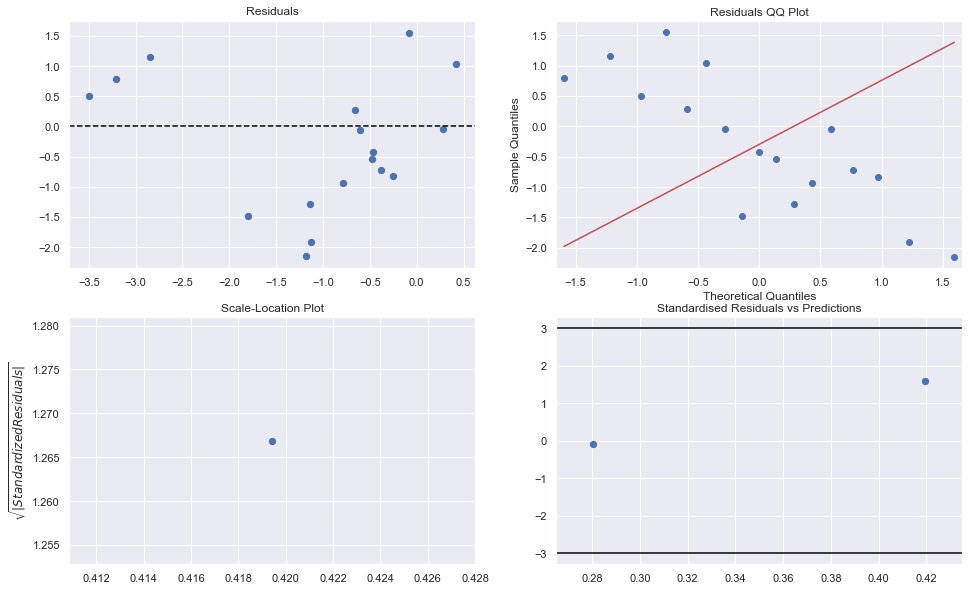

In [301]:

rf = RandomForestRegressor()
elasticnet = linear_model.ElasticNet(alpha=0.1, l1_ratio=0.1)

elastic_model = Pipeline([('scaler', scaler), 
                  ('elastic', elasticnet)])

X_cor_train = data['correlation']['train_datasets'][0]
y_cor_train = data['correlation']['train_datasets'][1]

X_cor_validate = data['correlation']['valid_datasets'][0]
y_cor_validate = data['correlation']['valid_datasets'][1]

print(X_cor_validate.shape)
print(y_cor_validate.shape)

plots_correlation = Plots('correlation_dataset')

model_correlation = Models(X_cor_train, y_cor_train, 'correlation_dataset')

elasticnet_scores = model_correlation.fit_cross_validated_model(elasticnet)
elasticnet_stats = model_correlation.calculate_cross_validation_stats(elasticnet_scores)
plots_correlation.plot_cross_validation_results(elasticnet_stats)
elasticnet_bestmodel, y_cor_validate_predictions = model_correlation.evaluate_cross_validated_models(elasticnet_scores, X_cor_validate, y_cor_validate)

print(y_cor_validate_predictions.shape)
print(y_cor_validate.shape)
plots_correlation.plot_prediction_vs_actuals(y_cor_validate_predictions, y_cor_validate)
plots_correlation.plot_residuals(y_cor_validate_predictions, y_cor_validate)

### Overall performance on the test set

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


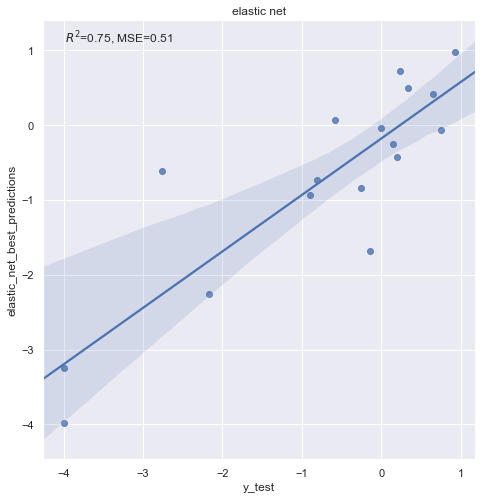

In [165]:
elastic_best_predictions = elastic_best.predict(X_test)
predictions_df = pd.DataFrame(elastic_best_predictions, columns=['elastic_net_best_predictions'])
predictions_df['y_test'] = y_test 


sns.pairplot(predictions_df, x_vars='y_test', y_vars='elastic_net_best_predictions', height=7, aspect=1, kind='reg')
plt.title("elastic net")
plt.annotate('$R^2$=%.2f, MSE=%.2f' % (metrics.r2_score(y_test, elastic_best_predictions), 
                                       metrics.mean_absolute_error(y_test, elastic_best_predictions)), 
             xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()

### Lasso selected dataset

Average MAE for elastic net regression model: 1.329 (+/- -0.860)
Average MSE for elastic net regression model: 3.344 (+/- -3.646)
Average R2 for elastic net regression model: -8.748 (+/- 6.040)


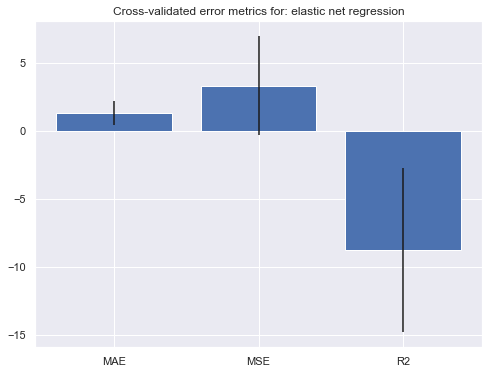

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


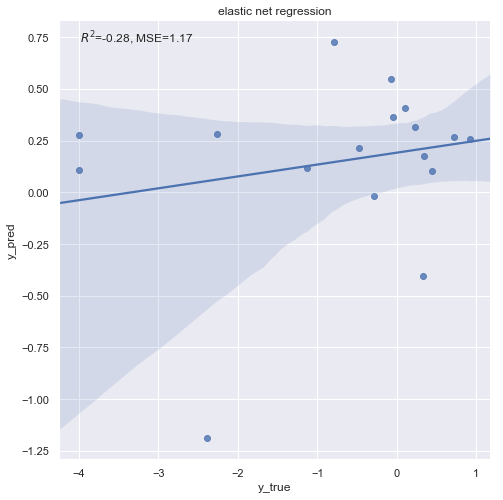

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in sqrt
/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in sqrt


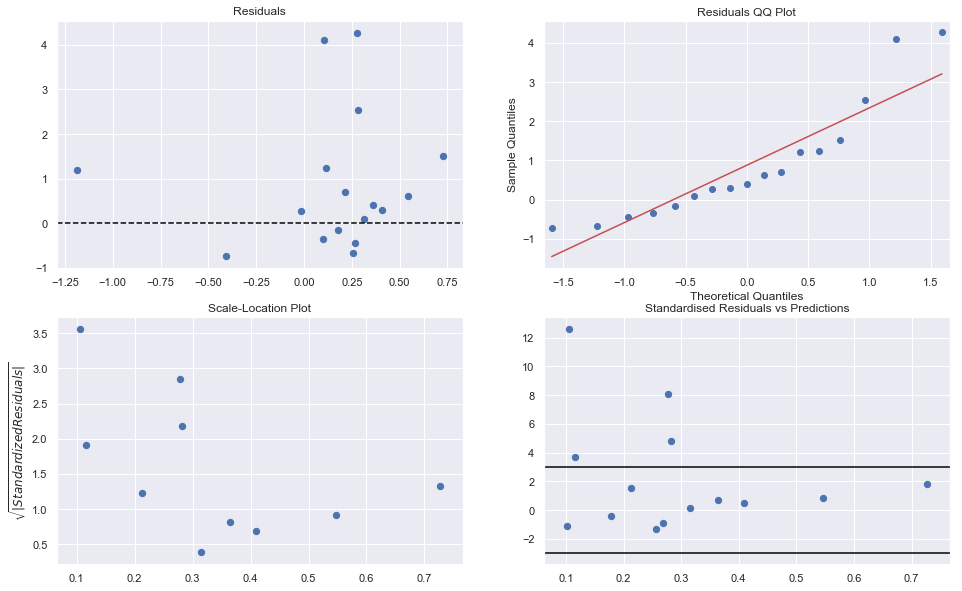

Model picked 30 variables and eliminated 31 variables
zero coefficients:  ['XLogP' 'nRotB' 'nAtomLAC' 'nAtomP' 'nBase' 'nAcid' 'nRings7' 'TopoPSA'
 'MDEC.12' 'MDEC.13' 'MDEC.33' 'MDEC.44' 'MDEO.11' 'MDEN.23' 'khs.dsCH'
 'khs.aaaC' 'khs.sNH2' 'khs.dsN' 'khs.sOH' 'khs.dO' 'khs.ddssS' 'khs.sBr'
 'FMF' 'SCH.6' 'ATSc4' 'Wlambda2.unity' 'Weta2.unity' 'BCUTw.1h'
 'BCUTc.1l' 'BCUTp.1l' 'RPCG']


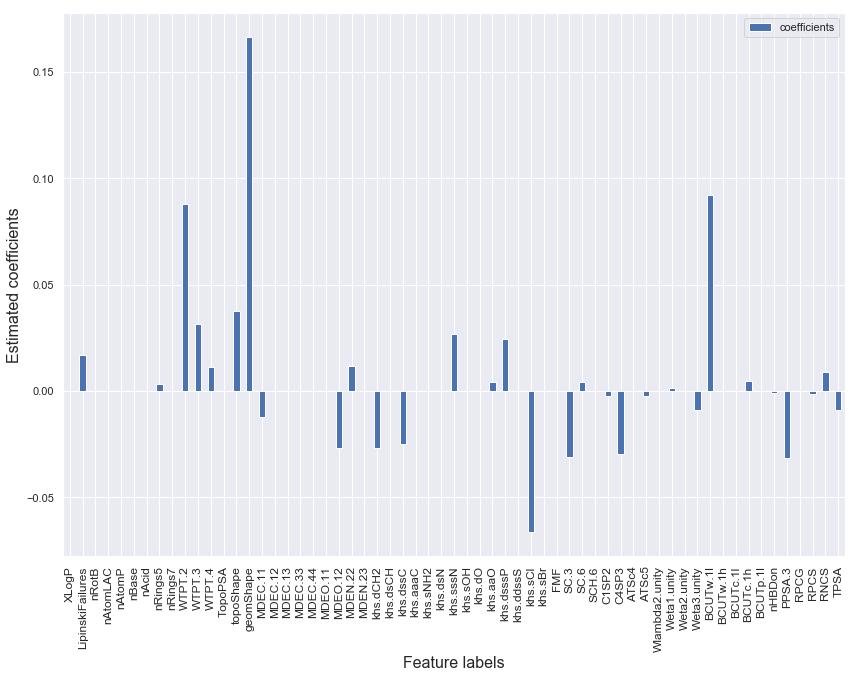

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


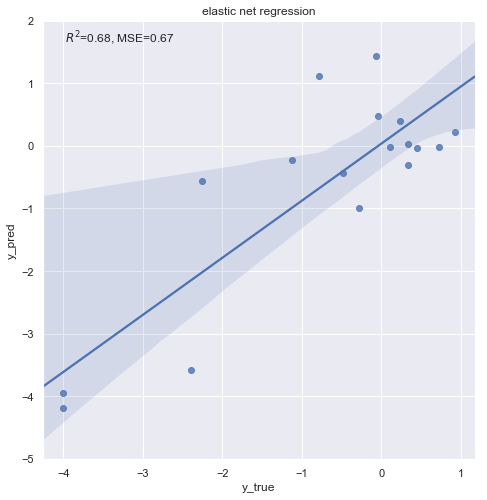

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in sqrt
/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in sqrt


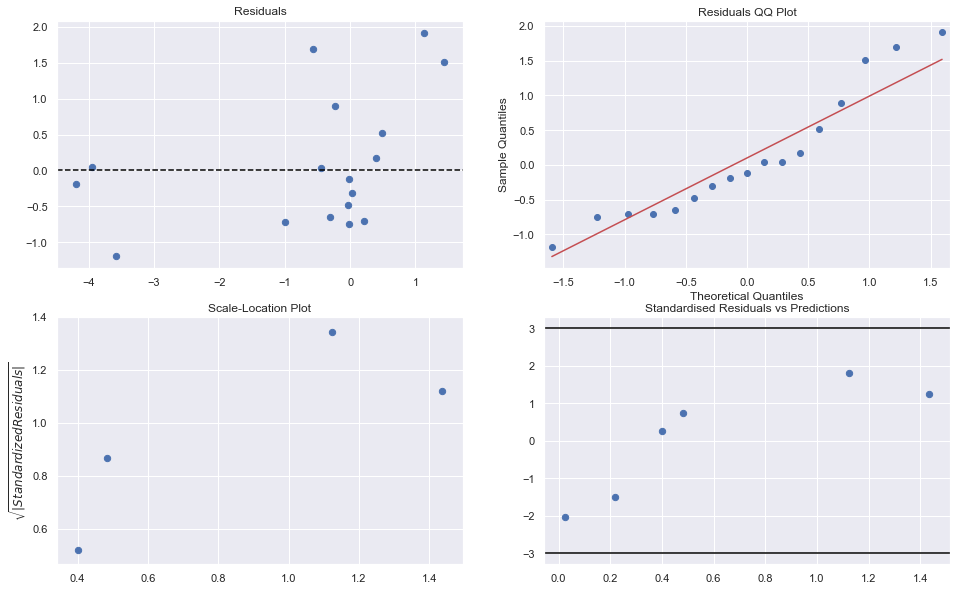

Model picked 53 variables and eliminated 8 variables
zero coefficients:  ['nRotB' 'MDEC.12' 'khs.dCH2' 'khs.aaaC' 'khs.sOH' 'khs.sCl' 'BCUTw.1h'
 'BCUTp.1l']


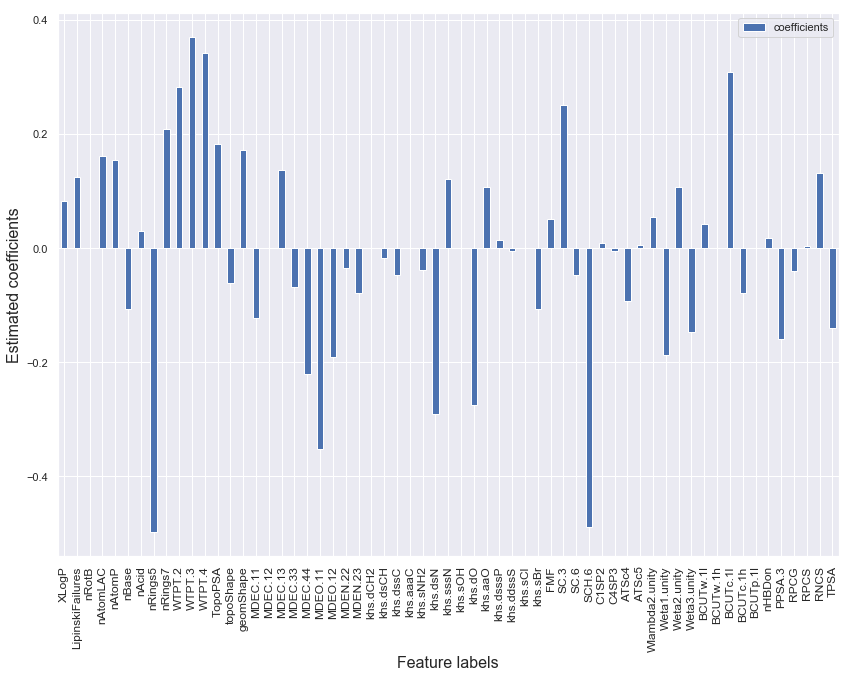

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


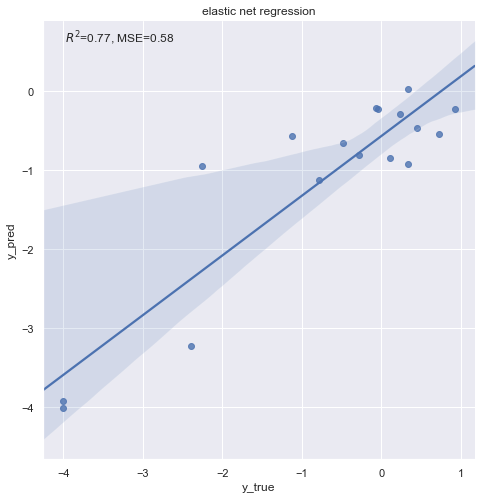

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in sqrt
/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in sqrt


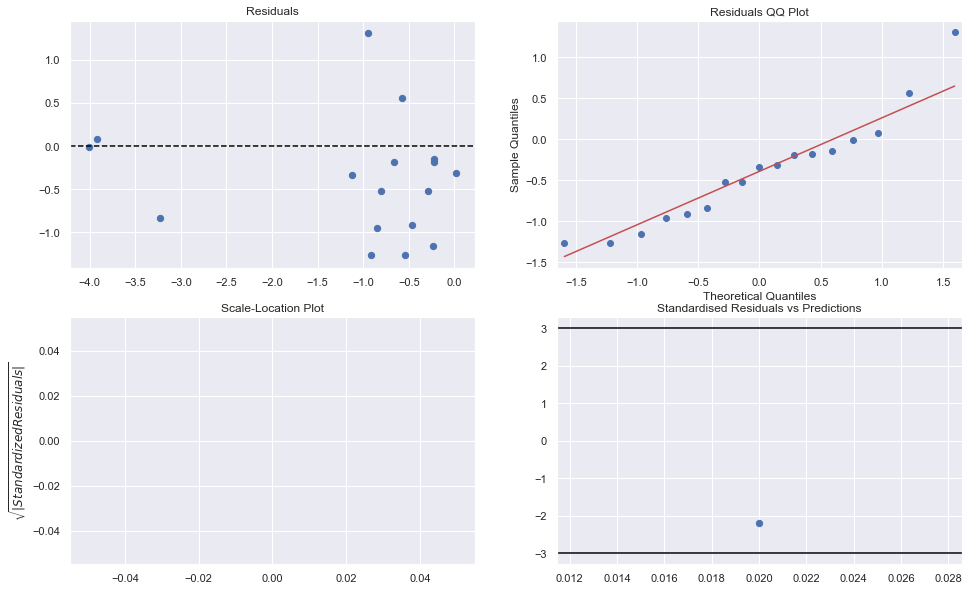

Model picked 47 variables and eliminated 14 variables
zero coefficients:  ['XLogP' 'LipinskiFailures' 'khs.dssC' 'khs.aaaC' 'khs.sNH2' 'khs.dsssP'
 'khs.ddssS' 'C1SP2' 'ATSc5' 'Weta3.unity' 'BCUTw.1h' 'RPCG' 'RPCS' 'RNCS']


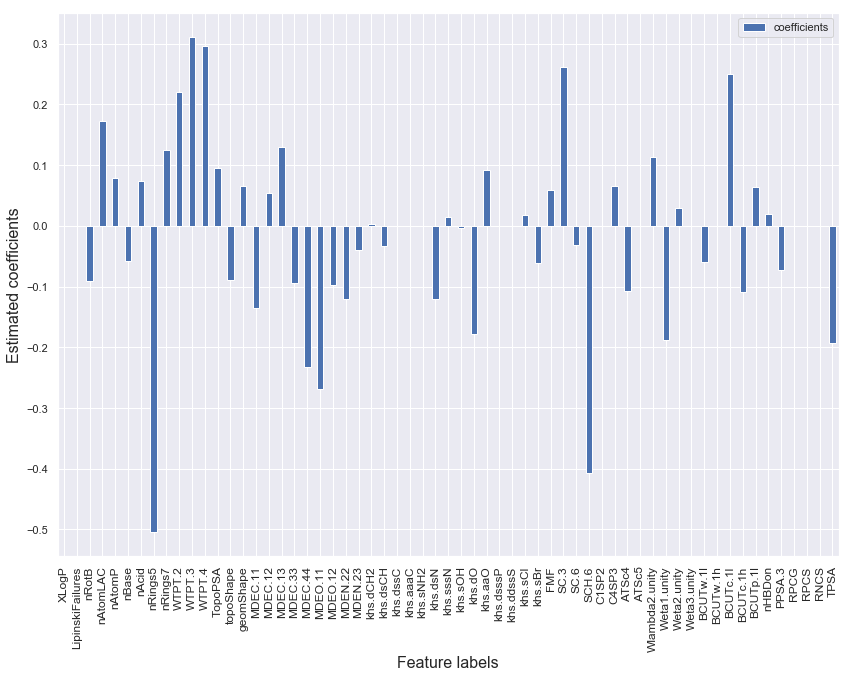

best model: 2 r2 score: 0.77


In [237]:
elasticnet = linear_model.ElasticNet(alpha=0.1, l1_ratio=0.1)

elastic_model = Pipeline([('scaler', scaler), 
                  ('elastic', elasticnet)])


columns = data['lasso']['df'].drop(columns=['y_var'], axis=1).columns.tolist()

elastic_scores = fit_model(data['lasso']['train_datasets'][0], data['lasso']['train_datasets'][1], 
                           elastic_model, 'elastic net regression')
elastic_best = evaluate_models(elastic_scores, data['lasso']['valid_datasets'][0], 
                               data['correlation']['valid_datasets'][1], 'elastic net regression', columns)


## Neural Network Models

### !! This section is not complete and needs more development/testing!!


In [39]:
# Initial hyperparameters were inspired by 
# "Development of QSAR models to predict and interpret the biological activity of artemisinin analogues"

# Best architecture: 10-5-1
# Sigmoid activation function 

def build_model_1(activation):
    model = tf.keras.Sequential([
    keras.layers.Dense(10, activation=activation, input_shape=(61,)),
    keras.layers.Dense(5, activation=activation),
    keras.layers.Dense(1)])
    # Configure a model for mean-squared error regression.
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(optimizer=optimizer,
                  loss='mse',       # mean squared error
                  metrics=['mae', 'mse'])  # mean absolute error
    return model

def build_model_2(activation):
    model = tf.keras.Sequential([
    # Adds a densely-connected layer with 10 units to the model:
    keras.layers.Dense(30, activation=activation, input_shape=(61,)),
    keras.layers.Dense(30, activation=activation),
    keras.layers.Dense(1)])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(optimizer=optimizer,
                  loss='mse',       # mean squared error
                  metrics=['mae', 'mse'])  # mean absolute error
    return model

def plot_history(history, title):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Abs Error')
    ax[0].plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    ax[0].plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    ax[0].set_title(title)
    #plt.ylim([0,5])
    ax[0].legend()
    
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Square Error')
    ax[1].plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    ax[1].plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    #plt.ylim([0,20])
    ax[1].set_title(title)
    ax[1].legend()
    plt.show()

def fit_model(activations, model_func, X_train, y_train):
    models = {}
    for act in activations:
        print("activation function: %s, model type: " % act)
        keras_model = model_func(act)

        # The patience parameter is the amount of epochs to check for improvement
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

        history = keras_model.fit(X_train, y_train, validation_split = 0.2, epochs=100, 
                            callbacks=[early_stop], batch_size=10, verbose=0)

        models[act] = keras_model
        plot_history(history, act)
        
        # Test
        loss, mae, mse = keras_model.evaluate(X_test_scaled, y_test, verbose=0)

        print("Testing set Mean Abs Error: {:5.2f} -Log RA".format(mae))
#         hist = pd.DataFrame(history.history)
#         hist['epoch'] = history.epoch
#         hist.tail()
    return models
    
def model_predict(model, X_test, y_test):
    # Predict
    predictions = model.predict(X_test)

    pred_scores = model.evaluate(X_test, y_test)
    print('Test loss:', pred_scores[0])
    print('Test accuracy:', pred_scores[1])

    results = pd.DataFrame(predictions, columns = ['y_pred'])
    #print(results, y_test)
    #results.columns = ['y_pred']
    results['y_true'] = y_test.reset_index()['y_var']
    sns.pairplot(results, x_vars='y_true', y_vars='y_pred', height=7, aspect=1, kind='reg')
    plt.title("Neural network model")
    plt.annotate('$R^2$=%.2f, MSE=%.2f' % (metrics.r2_score(y_test, predictions), metrics.mean_absolute_error(y_test, predictions)), xy=(0.05, 0.95), xycoords='axes fraction')
    plt.show()

    print("prediction dataframe: \n", results.head(4))
    error = abs(results['y_true'] - results['y_pred'])
    plt.figure(figsize=(8,6))
    plt.hist(error, bins=5)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    plt.show()

---------------
Model 1: 10-5-1
---------------
activation function: sigmoid, model type: 


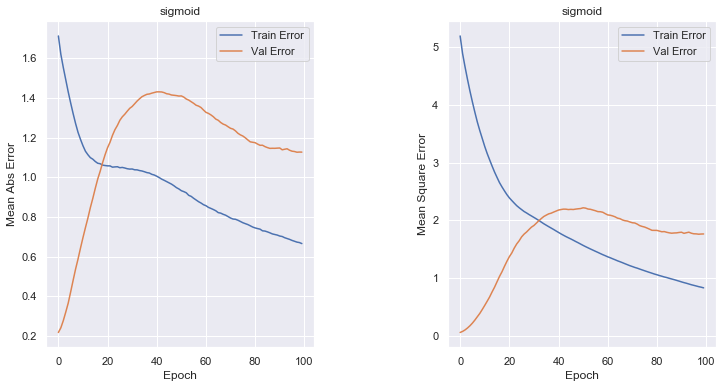

Testing set Mean Abs Error:  0.98 -Log RA
activation function: relu, model type: 


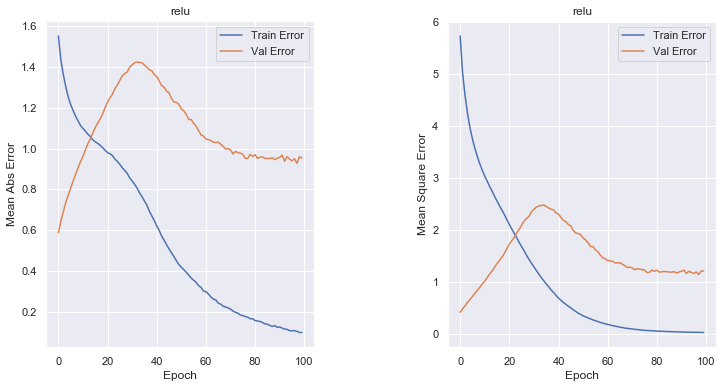

Testing set Mean Abs Error:  0.65 -Log RA
---------------
Model 2: 30-30-1
---------------
activation function: sigmoid, model type: 


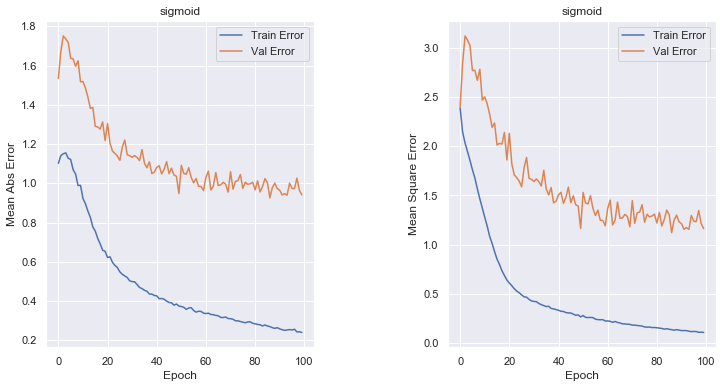

Testing set Mean Abs Error:  0.70 -Log RA
activation function: relu, model type: 


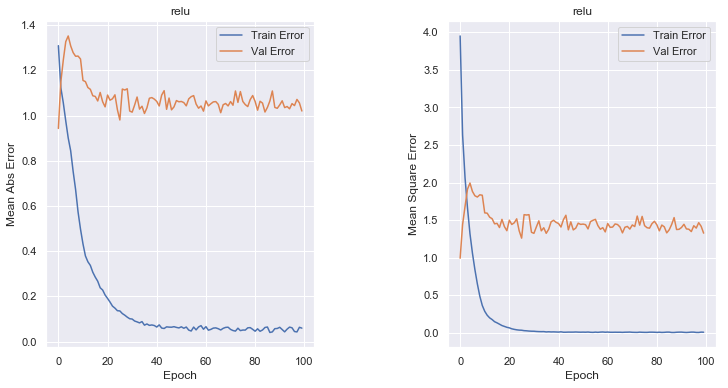

Testing set Mean Abs Error:  0.84 -Log RA


In [40]:
activation_functions = ['sigmoid', 'relu']


print("---------------")
print("Model 1: 10-5-1")
print("---------------")
models_1 = fit_model(activation_functions, build_model_1, X_train_scaled, y_train)
print("---------------")
print("Model 2: 30-30-1")
print("---------------")
models_2 = fit_model(activation_functions, build_model_2, X_train_scaled, y_train)

---Prediction----
36/36 [==============================] - 0s 72us/sample - loss: 1.6942 - mean_absolute_error: 0.9970 - mean_squared_error: 1.6942
Test loss: 1.6941644847393036
Test accuracy: 0.99701107


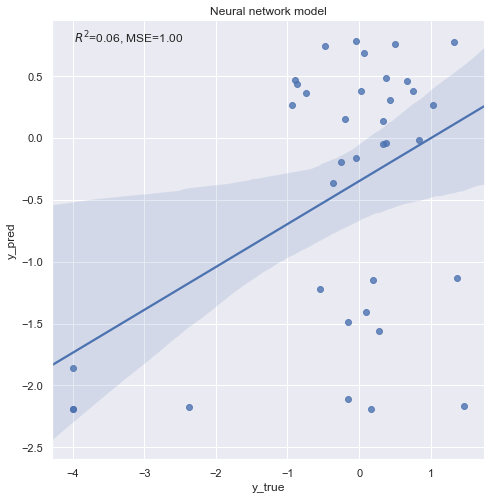

prediction dataframe: 
      y_pred  y_true
0 -1.223621   -0.55
1 -1.405894    0.10
2  0.774398    1.32
3  0.381029    0.02


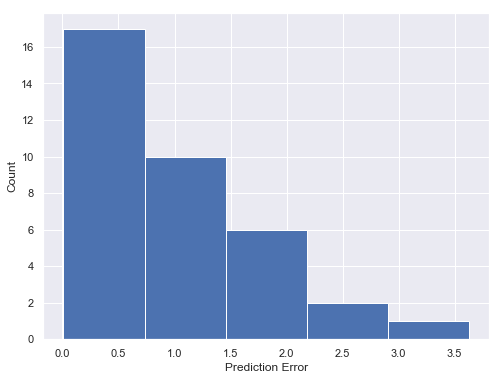

36/36 [==============================] - 0s 59us/sample - loss: 1.1266 - mean_absolute_error: 0.7672 - mean_squared_error: 1.1266
Test loss: 1.1265912983152602
Test accuracy: 0.7672243


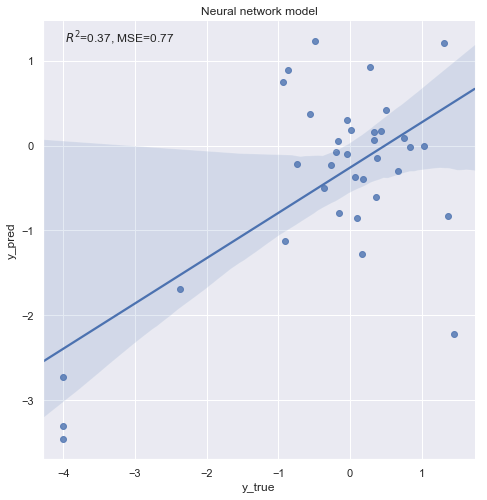

prediction dataframe: 
      y_pred  y_true
0  0.371082   -0.55
1 -0.855063    0.10
2  1.208614    1.32
3  0.185147    0.02


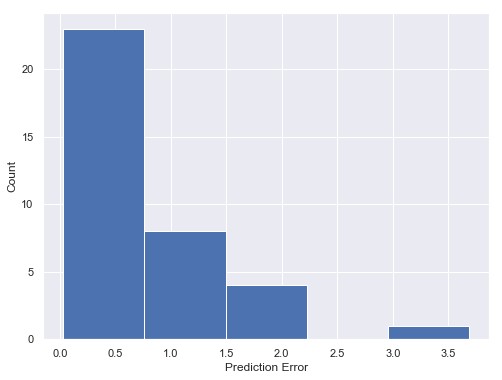

In [25]:
print("---Prediction----")

for m in models_1:
    #print(models[m])
    model_predict(models_1[m], X_test_scaled, y_test)

In [27]:
example_batch = X_train_scaled[:10]
example_result = models_1['sigmoid'].predict(example_batch)
example_result

array([[-1.6937764 ],
       [-1.4271785 ],
       [ 0.14019111],
       [-2.0600002 ],
       [-2.0043669 ],
       [-0.06624839],
       [ 0.05327615],
       [ 0.14529395],
       [-2.0459526 ],
       [ 0.2721492 ]], dtype=float32)